# Adversarial Attacks

In Part 1, you will implement a simple adversarial attack on MNIST images. In the second part, you implement the same adversarial attack on CIFAR-10 images. In the third and final part, you will take a picture of an item you would expect to find in CIFAR-10 and use your trained model to generate an adversarial example.

**Imports:**

In [1]:
## Standard Library
import time
import struct

## External Library
import numpy as np
import matplotlib.pyplot as plt

## Pytorch Imports
import torch
import torch.nn as nn
import torch.utils.data
from torch.autograd import Variable

In [2]:
gpu_boole = torch.cuda.is_available()
print(gpu_boole)

True


In [ ]:
## Mount Google Drive Data (If using Google Colaboratory)
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g7B9T3qa24UIKGOtWw9m6fkTQurAAkb51m-5A8NkAS62alM3pQQ6b8
Mounted at /content/gdrive


### Part 1: MNIST Attack

**Defining the model and optimizer**

In [18]:
## Defining the model:
class Net(nn.Module):
    def __init__(self, input_size, width, num_classes):
        super(Net, self).__init__()

        ##feedfoward layers:
        self.ff1 = nn.Linear(input_size, width) #input

        self.ff2 = nn.Linear(width, width) #hidden layers
        self.ff3 = nn.Linear(width, width)

        self.ff_out = nn.Linear(width, num_classes) #logit layer     

        ##activations:
        self.relu = nn.ReLU()
                
    def forward(self, input_data):
        out = self.relu(self.ff1(input_data)) 
        out = self.relu(self.ff2(out)) 
        out = self.relu(self.ff3(out))
        out = self.ff_out(out)
        return out #returns class probabilities for each image

net = Net(input_size = 784, width = 500, num_classes = 10)
if gpu_boole:
    net = net.cuda()

optimizer = torch.optim.SGD(net.parameters(), lr = 0.01)
loss_metric = nn.CrossEntropyLoss()


**Data pipeline:**

In [6]:
#Downloading and unzipping MNIST data files:
!curl -O http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
!gunzip t*-ubyte.gz -f

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9680k  100 9680k    0     0  33114      0  0:04:59  0:04:59 --:--:-- 32466
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28881  100 28881    0     0  47268      0 --:--:-- --:--:-- --:--:-- 47191
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1610k  100 1610k    0     0  32321      0  0:00:51  0:00:51 --:--:-- 31272
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4542  100  4542    0     0  10944      0 --:--:-- --:--:-- --:--:-- 10918


In [7]:
##Loading files into numpy arrays:
def read_idx(filename, boole=0):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        if boole:
            return np.fromstring(f.read(), dtype=np.uint8).reshape(shape).astype(np.float32)*10     
        else:
            return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)

xtrain = read_idx('train-images-idx3-ubyte', 1)
xtest = read_idx('t10k-images-idx3-ubyte', 1)
ytrain = read_idx('train-labels-idx1-ubyte')
ytest = read_idx('t10k-labels-idx1-ubyte')


xtrain = torch.Tensor(xtrain)
xtrain /= xtrain.max()
ytrain = torch.Tensor(ytrain).long()
xtest = torch.Tensor(xtest)
xtest /= xtest.max()
ytest = torch.Tensor(ytest).long()

## data_loaders:
train = torch.utils.data.TensorDataset(xtrain, ytrain)
test = torch.utils.data.TensorDataset(xtest, ytest)
train_loader = torch.utils.data.DataLoader(train, batch_size=128)
test_loader = torch.utils.data.DataLoader(test, batch_size=128, shuffle=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if __name__ == '__main__':


**Implement your adversarial attack here:**

In [8]:
class GradientAttack():
        
        """
        Try to use FGSM Adversarial Attack Methods here
        """
        
        def __init__(self, loss, epsilon):
            """
            
            """
            self.loss = loss
            self.epsilon = epsilon

        def forward(self, x, y_true, model):
            """
            
            """
            # TODO: Implement a one step gradient attack
            # Step 1: Calculate the Loss and then calculate the
            # gradient of the Loss w.r.t the image

            # Step 2: Add the gradient (or its sign for each pixel),
            # multiplied by a small step size, to 
            # the original image
            # you might need to clamp the modified image to 
            # make sure the values of each pixel are between [0,1]

            output = model(x)
            loss_ = self.loss(output,y_true)
            loss_.backward()
            x_grad = x.grad.data
            sign_x_grad = x_grad.sign()
            perturbed_x = x + self.epsilon*sign_x_grad 
            perturbed_x = torch.clamp(perturbed_x, 0, 1)

            return perturbed_x             

In [9]:
## Initialize The Attack
adv_attack = GradientAttack(loss_metric, 0.1)

In [10]:
## Evaluation Functions (E.g Loss, Accuracy)
def train_eval(verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    for images, labels in train_loader:
        if gpu_boole:
            images, labels = images.cuda(), labels.cuda()
        images = images.view(-1, 28*28)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.float() == labels.float()).sum()

        loss_sum += loss_metric(outputs,labels).item()
        
    if verbose:
        print('Train accuracy: %f %%' % (100.0 * correct / total))
        print('Train loss: %f' % (loss_sum / total))

    return 100.0 * correct / total, loss_sum / total
    
def test_eval(verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    for images, labels in test_loader:
        if gpu_boole:
            images, labels = images.cuda(), labels.cuda()
        images = images.view(-1, 28*28)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.float() == labels.float()).sum()

        loss_sum += loss_metric(outputs,labels).item()

    if verbose:
        print('Test accuracy: %f %%' % (100.0 * correct / total))
        print('Test loss: %f' % (loss_sum / total))

    return 100.0 * correct / total, loss_sum / total

def test_eval_adv(verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    for images, labels in test_loader:
        if gpu_boole:
            images, labels = images.cuda(), labels.cuda()
        images = images.view(-1, 28*28)
        images = Variable(images, requires_grad=True)
        images = adv_attack.forward(images, Variable(labels), net)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.float() == labels.float()).sum()

        loss_sum += loss_metric(outputs,labels).item()

    if verbose:
        print('Test accuracy adversarial: %f %%' % (100.0 * correct / total))
        print('Test loss adversarial: %f' % (loss_sum / total))

    return 100.0 * correct / total, loss_sum / total


**Training Loop:** Your adverarial accuracy will also be printed in the loop.

Starting Training
Epoch 1 :
Train accuracy: 50.401669 %
Train loss: 0.017499
Test accuracy: 50.730000 %
Test loss: 0.017672
Test accuracy adversarial: 17.230000 %
Test loss adversarial: 0.018182
Elapsed time for epoch: 2.040428638458252 s
ETA of completion: 2.6865643739700316 minutes



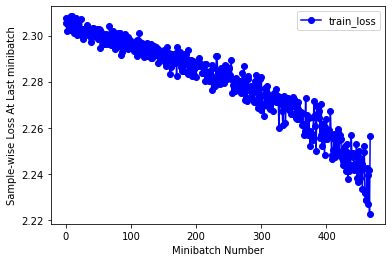

Epoch 2 :
Train accuracy: 63.715000 %
Train loss: 0.011866
Test accuracy: 63.619999 %
Test loss: 0.011871
Test accuracy adversarial: 36.119999 %
Test loss adversarial: 0.015438
Elapsed time for epoch: 2.0191400051116943 s
ETA of completion: 2.6248820066452025 minutes



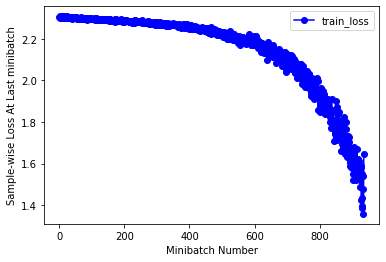

Epoch 3 :
Train accuracy: 80.613335 %
Train loss: 0.005312
Test accuracy: 81.129997 %
Test loss: 0.005225
Test accuracy adversarial: 30.670000 %
Test loss adversarial: 0.013988
Elapsed time for epoch: 1.971675157546997 s
ETA of completion: 2.5303164521853128 minutes



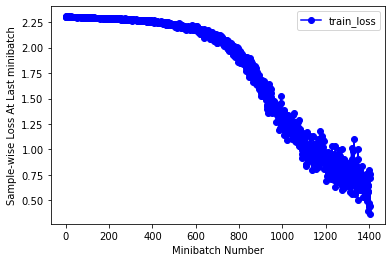

Epoch 4 :
Train accuracy: 85.403336 %
Train loss: 0.003887
Test accuracy: 85.659996 %
Test loss: 0.003798
Test accuracy adversarial: 30.250000 %
Test loss adversarial: 0.015210
Elapsed time for epoch: 2.0358731746673584 s
ETA of completion: 2.578772687911987 minutes



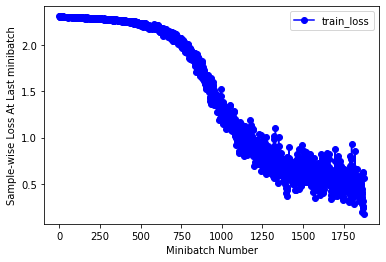

Epoch 5 :
Train accuracy: 87.635002 %
Train loss: 0.003290
Test accuracy: 87.689995 %
Test loss: 0.003214
Test accuracy adversarial: 29.369999 %
Test loss adversarial: 0.016298
Elapsed time for epoch: 2.0662431716918945 s
ETA of completion: 2.582803964614868 minutes



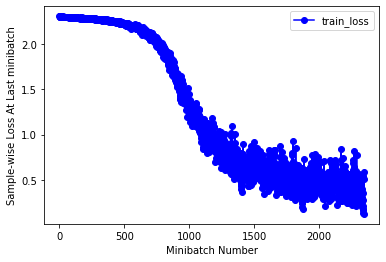

Epoch 6 :
Train accuracy: 88.901665 %
Train loss: 0.002960
Test accuracy: 88.900002 %
Test loss: 0.002899
Test accuracy adversarial: 28.279999 %
Test loss adversarial: 0.017245
Elapsed time for epoch: 2.1117939949035645 s
ETA of completion: 2.6045459270477296 minutes



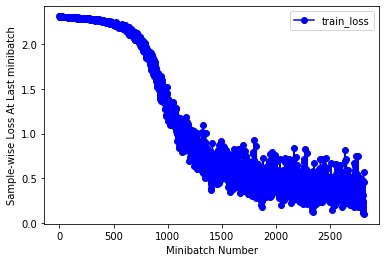

Epoch 7 :
Train accuracy: 89.711670 %
Train loss: 0.002744
Test accuracy: 89.829994 %
Test loss: 0.002693
Test accuracy adversarial: 27.260000 %
Test loss adversarial: 0.017995
Elapsed time for epoch: 1.9808595180511475 s
ETA of completion: 2.4100457469622296 minutes



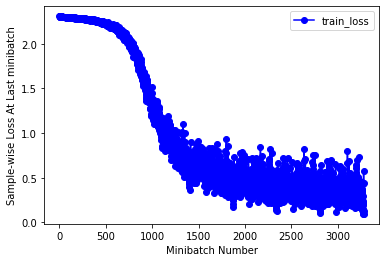

Epoch 8 :
Train accuracy: 90.408333 %
Train loss: 0.002579
Test accuracy: 90.329994 %
Test loss: 0.002536
Test accuracy adversarial: 26.549999 %
Test loss adversarial: 0.018539
Elapsed time for epoch: 1.969069480895996 s
ETA of completion: 2.362883377075195 minutes



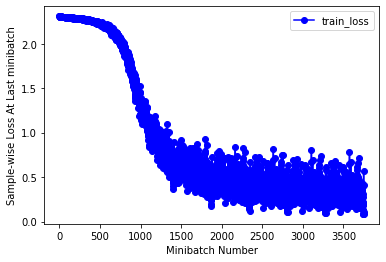

Epoch 9 :
Train accuracy: 90.970001 %
Train loss: 0.002440
Test accuracy: 90.759995 %
Test loss: 0.002402
Test accuracy adversarial: 26.090000 %
Test loss adversarial: 0.018952
Elapsed time for epoch: 2.0614349842071533 s
ETA of completion: 2.439364731311798 minutes



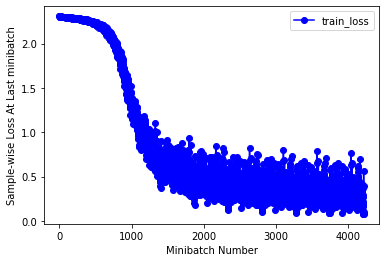

Epoch 10 :
Train accuracy: 91.455002 %
Train loss: 0.002314
Test accuracy: 91.379997 %
Test loss: 0.002281
Test accuracy adversarial: 25.699999 %
Test loss adversarial: 0.019261
Elapsed time for epoch: 2.0424556732177734 s
ETA of completion: 2.3828649520874023 minutes



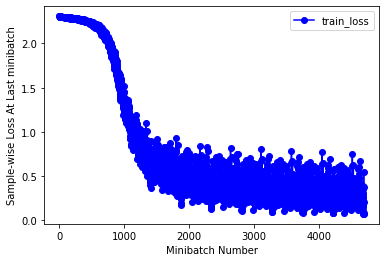

Epoch 11 :
Train accuracy: 91.881668 %
Train loss: 0.002198
Test accuracy: 91.790001 %
Test loss: 0.002170
Test accuracy adversarial: 25.119999 %
Test loss adversarial: 0.019517
Elapsed time for epoch: 2.0026743412017822 s
ETA of completion: 2.3030754923820496 minutes



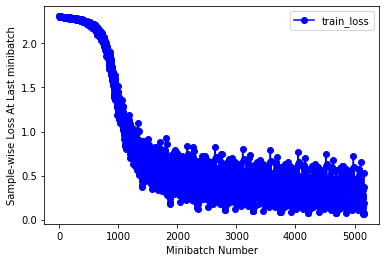

Epoch 12 :
Train accuracy: 92.298332 %
Train loss: 0.002088
Test accuracy: 92.199997 %
Test loss: 0.002066
Test accuracy adversarial: 24.930000 %
Test loss adversarial: 0.019740
Elapsed time for epoch: 2.0145530700683594 s
ETA of completion: 2.2831601460774738 minutes



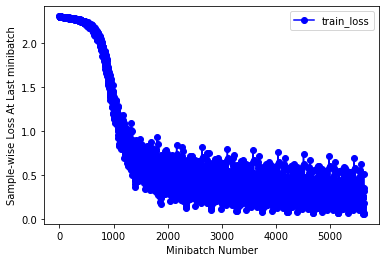

Epoch 13 :
Train accuracy: 92.648331 %
Train loss: 0.001985
Test accuracy: 92.599998 %
Test loss: 0.001967
Test accuracy adversarial: 24.869999 %
Test loss adversarial: 0.019955
Elapsed time for epoch: 1.9607696533203125 s
ETA of completion: 2.189526112874349 minutes



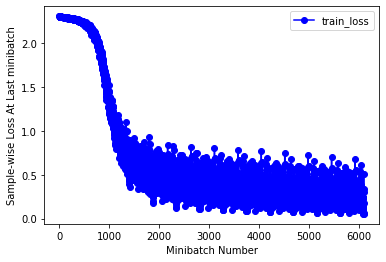

Epoch 14 :
Train accuracy: 93.050003 %
Train loss: 0.001887
Test accuracy: 93.029999 %
Test loss: 0.001874
Test accuracy adversarial: 24.680000 %
Test loss adversarial: 0.020165
Elapsed time for epoch: 1.981978416442871 s
ETA of completion: 2.180176258087158 minutes



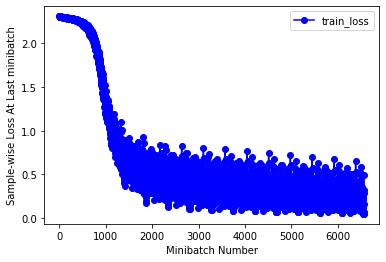

Epoch 15 :
Train accuracy: 93.395004 %
Train loss: 0.001796
Test accuracy: 93.379997 %
Test loss: 0.001786
Test accuracy adversarial: 24.599998 %
Test loss adversarial: 0.020379
Elapsed time for epoch: 1.9946722984313965 s
ETA of completion: 2.160894989967346 minutes



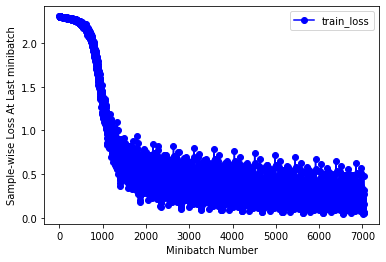

Epoch 16 :
Train accuracy: 93.721664 %
Train loss: 0.001708
Test accuracy: 93.659996 %
Test loss: 0.001703
Test accuracy adversarial: 24.420000 %
Test loss adversarial: 0.020591
Elapsed time for epoch: 2.0285143852233887 s
ETA of completion: 2.1637486775716144 minutes



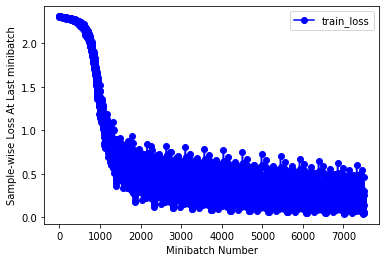

Epoch 17 :
Train accuracy: 94.038338 %
Train loss: 0.001627
Test accuracy: 93.989998 %
Test loss: 0.001625
Test accuracy adversarial: 23.900000 %
Test loss adversarial: 0.020828
Elapsed time for epoch: 2.053128957748413 s
ETA of completion: 2.1557854056358337 minutes



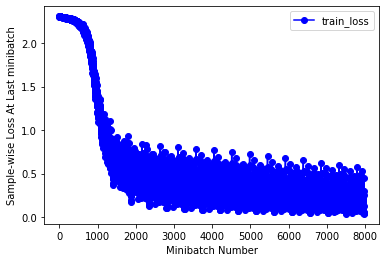

Epoch 18 :
Train accuracy: 94.313332 %
Train loss: 0.001551
Test accuracy: 94.279999 %
Test loss: 0.001552
Test accuracy adversarial: 23.549999 %
Test loss adversarial: 0.021098
Elapsed time for epoch: 2.010126829147339 s
ETA of completion: 2.0771310567855834 minutes



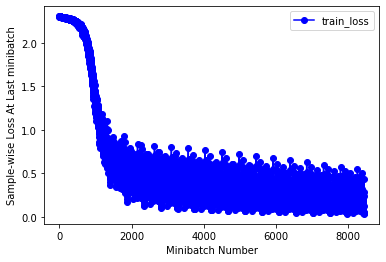

Epoch 19 :
Train accuracy: 94.563332 %
Train loss: 0.001480
Test accuracy: 94.509995 %
Test loss: 0.001485
Test accuracy adversarial: 23.119999 %
Test loss adversarial: 0.021377
Elapsed time for epoch: 2.0326497554779053 s
ETA of completion: 2.0665272514025372 minutes



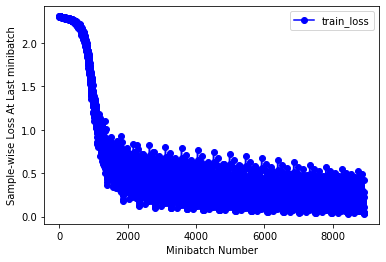

Epoch 20 :
Train accuracy: 94.800003 %
Train loss: 0.001413
Test accuracy: 94.779999 %
Test loss: 0.001422
Test accuracy adversarial: 22.820000 %
Test loss adversarial: 0.021671
Elapsed time for epoch: 1.930159091949463 s
ETA of completion: 1.930159091949463 minutes



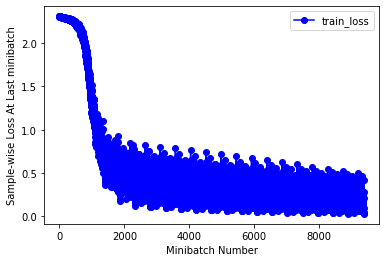

Epoch 21 :
Train accuracy: 95.020004 %
Train loss: 0.001352
Test accuracy: 94.949997 %
Test loss: 0.001364
Test accuracy adversarial: 22.699999 %
Test loss adversarial: 0.021973
Elapsed time for epoch: 1.9478158950805664 s
ETA of completion: 1.9153522968292236 minutes



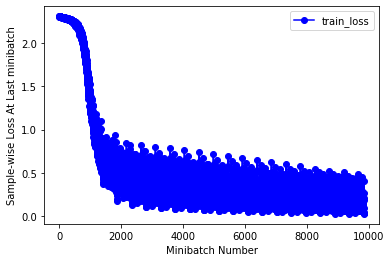

Epoch 22 :
Train accuracy: 95.260002 %
Train loss: 0.001294
Test accuracy: 95.189995 %
Test loss: 0.001311
Test accuracy adversarial: 22.320000 %
Test loss adversarial: 0.022270
Elapsed time for epoch: 1.9238829612731934 s
ETA of completion: 1.8597535292307537 minutes



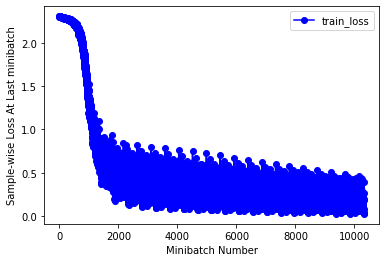

Epoch 23 :
Train accuracy: 95.450005 %
Train loss: 0.001239
Test accuracy: 95.339996 %
Test loss: 0.001261
Test accuracy adversarial: 21.820000 %
Test loss adversarial: 0.022573
Elapsed time for epoch: 1.9621524810791016 s
ETA of completion: 1.8640448570251464 minutes



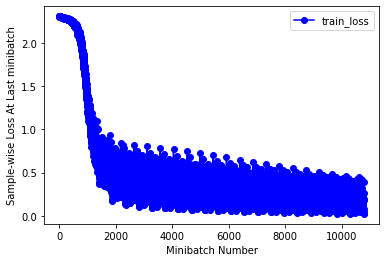

Epoch 24 :
Train accuracy: 95.633331 %
Train loss: 0.001188
Test accuracy: 95.470001 %
Test loss: 0.001215
Test accuracy adversarial: 21.600000 %
Test loss adversarial: 0.022903
Elapsed time for epoch: 1.988767147064209 s
ETA of completion: 1.8561826705932618 minutes



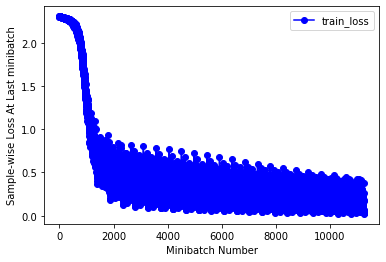

Epoch 25 :
Train accuracy: 95.801666 %
Train loss: 0.001140
Test accuracy: 95.570000 %
Test loss: 0.001173
Test accuracy adversarial: 21.240000 %
Test loss adversarial: 0.023228
Elapsed time for epoch: 1.9410054683685303 s
ETA of completion: 1.7792550126711528 minutes



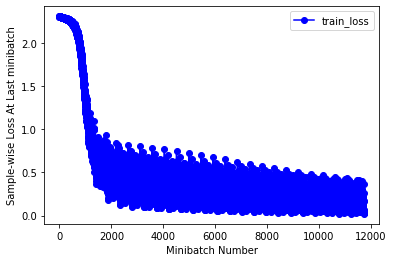

Epoch 26 :
Train accuracy: 95.934998 %
Train loss: 0.001095
Test accuracy: 95.680000 %
Test loss: 0.001134
Test accuracy adversarial: 20.850000 %
Test loss adversarial: 0.023553
Elapsed time for epoch: 1.9534671306610107 s
ETA of completion: 1.7581204175949097 minutes



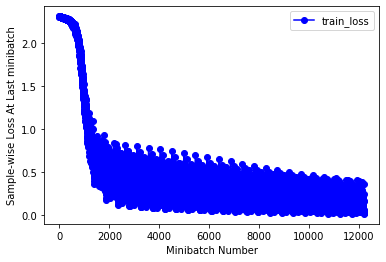

Epoch 27 :
Train accuracy: 96.126671 %
Train loss: 0.001053
Test accuracy: 95.790001 %
Test loss: 0.001098
Test accuracy adversarial: 20.469999 %
Test loss adversarial: 0.023877
Elapsed time for epoch: 1.9507944583892822 s
ETA of completion: 1.7232017715771992 minutes



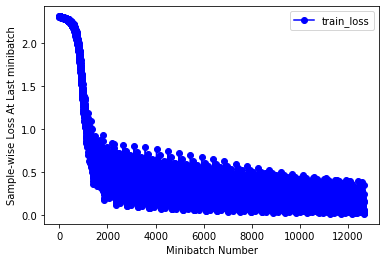

Epoch 28 :
Train accuracy: 96.294998 %
Train loss: 0.001013
Test accuracy: 95.939995 %
Test loss: 0.001064
Test accuracy adversarial: 20.240000 %
Test loss adversarial: 0.024227
Elapsed time for epoch: 2.0743720531463623 s
ETA of completion: 1.7977891127268473 minutes



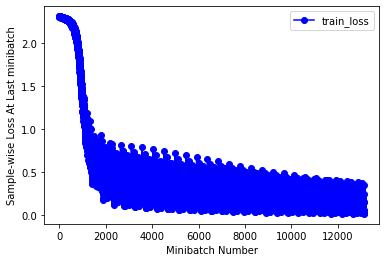

Epoch 29 :
Train accuracy: 96.436668 %
Train loss: 0.000976
Test accuracy: 96.019997 %
Test loss: 0.001034
Test accuracy adversarial: 19.879999 %
Test loss adversarial: 0.024579
Elapsed time for epoch: 2.038802146911621 s
ETA of completion: 1.7329818248748778 minutes



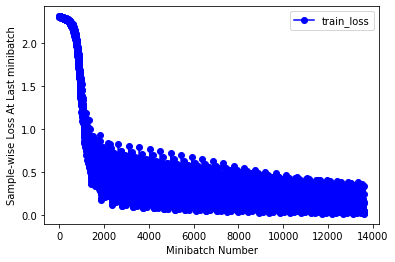

Epoch 30 :
Train accuracy: 96.555000 %
Train loss: 0.000941
Test accuracy: 96.070000 %
Test loss: 0.001005
Test accuracy adversarial: 19.670000 %
Test loss adversarial: 0.024943
Elapsed time for epoch: 2.104555606842041 s
ETA of completion: 1.7537963390350342 minutes



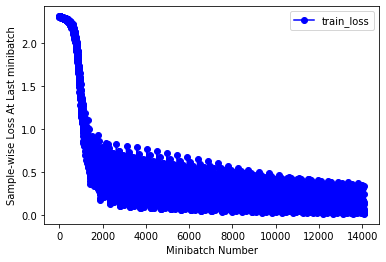

Epoch 31 :
Train accuracy: 96.690002 %
Train loss: 0.000907
Test accuracy: 96.199997 %
Test loss: 0.000979
Test accuracy adversarial: 19.270000 %
Test loss adversarial: 0.025304
Elapsed time for epoch: 1.983384370803833 s
ETA of completion: 1.6197639028231303 minutes



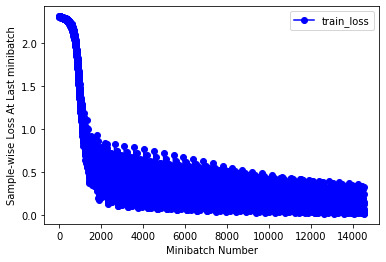

Epoch 32 :
Train accuracy: 96.790001 %
Train loss: 0.000876
Test accuracy: 96.250000 %
Test loss: 0.000954
Test accuracy adversarial: 18.969999 %
Test loss adversarial: 0.025673
Elapsed time for epoch: 2.0423972606658936 s
ETA of completion: 1.6339178085327148 minutes



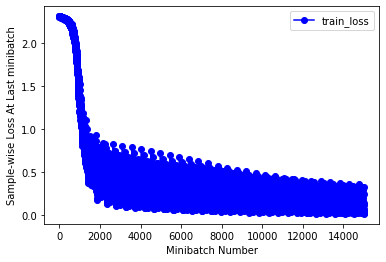

Epoch 33 :
Train accuracy: 96.883331 %
Train loss: 0.000846
Test accuracy: 96.360001 %
Test loss: 0.000931
Test accuracy adversarial: 18.609999 %
Test loss adversarial: 0.026059
Elapsed time for epoch: 2.0699386596679688 s
ETA of completion: 1.6214519500732423 minutes



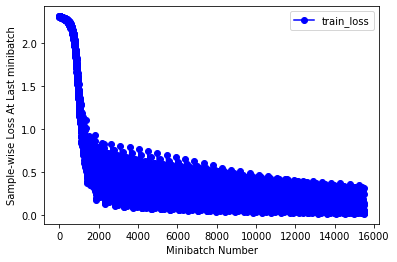

Epoch 34 :
Train accuracy: 96.980003 %
Train loss: 0.000818
Test accuracy: 96.449997 %
Test loss: 0.000910
Test accuracy adversarial: 18.459999 %
Test loss adversarial: 0.026442
Elapsed time for epoch: 2.0475540161132812 s
ETA of completion: 1.5697914123535157 minutes



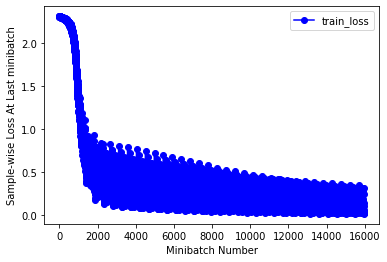

Epoch 35 :
Train accuracy: 97.078331 %
Train loss: 0.000792
Test accuracy: 96.509995 %
Test loss: 0.000890
Test accuracy adversarial: 18.199999 %
Test loss adversarial: 0.026844
Elapsed time for epoch: 2.0732996463775635 s
ETA of completion: 1.5549747347831726 minutes



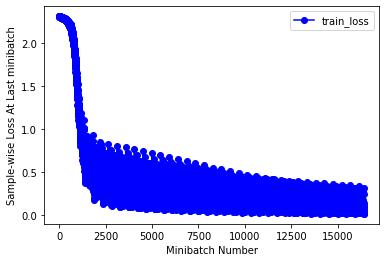

Epoch 36 :
Train accuracy: 97.158333 %
Train loss: 0.000766
Test accuracy: 96.540001 %
Test loss: 0.000872
Test accuracy adversarial: 17.719999 %
Test loss adversarial: 0.027246
Elapsed time for epoch: 2.0086774826049805 s
ETA of completion: 1.473030153910319 minutes



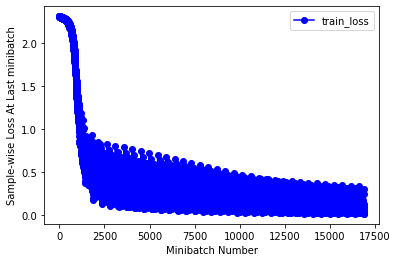

Epoch 37 :
Train accuracy: 97.270004 %
Train loss: 0.000742
Test accuracy: 96.610001 %
Test loss: 0.000855
Test accuracy adversarial: 17.420000 %
Test loss adversarial: 0.027664
Elapsed time for epoch: 1.9810502529144287 s
ETA of completion: 1.4197526812553405 minutes



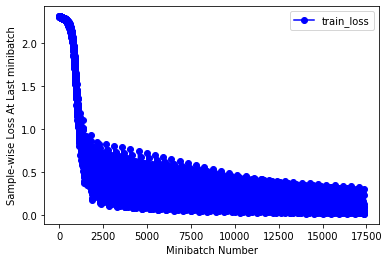

Epoch 38 :
Train accuracy: 97.370003 %
Train loss: 0.000719
Test accuracy: 96.639999 %
Test loss: 0.000839
Test accuracy adversarial: 17.119999 %
Test loss adversarial: 0.028091
Elapsed time for epoch: 2.015946388244629 s
ETA of completion: 1.4111624717712403 minutes



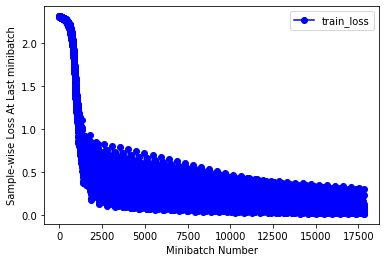

Epoch 39 :
Train accuracy: 97.434998 %
Train loss: 0.000697
Test accuracy: 96.699997 %
Test loss: 0.000824
Test accuracy adversarial: 16.869999 %
Test loss adversarial: 0.028542
Elapsed time for epoch: 2.092853546142578 s
ETA of completion: 1.430116589864095 minutes



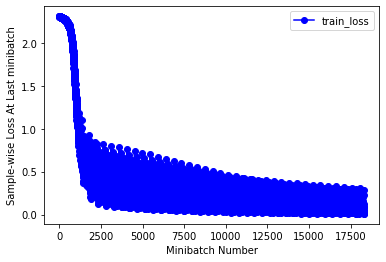

Epoch 40 :
Train accuracy: 97.528336 %
Train loss: 0.000676
Test accuracy: 96.739998 %
Test loss: 0.000810
Test accuracy adversarial: 16.559999 %
Test loss adversarial: 0.028988
Elapsed time for epoch: 2.0577545166015625 s
ETA of completion: 1.3718363444010417 minutes



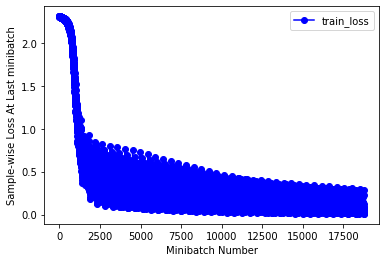

Epoch 41 :
Train accuracy: 97.603333 %
Train loss: 0.000656
Test accuracy: 96.809998 %
Test loss: 0.000796
Test accuracy adversarial: 16.410000 %
Test loss adversarial: 0.029416
Elapsed time for epoch: 2.069805860519409 s
ETA of completion: 1.345373809337616 minutes



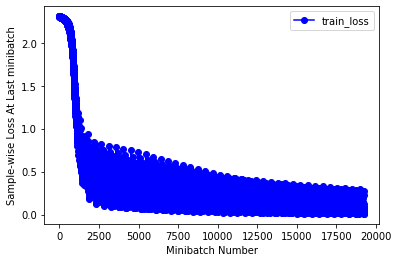

Epoch 42 :
Train accuracy: 97.698334 %
Train loss: 0.000636
Test accuracy: 96.889999 %
Test loss: 0.000783
Test accuracy adversarial: 16.219999 %
Test loss adversarial: 0.029863
Elapsed time for epoch: 1.9710040092468262 s
ETA of completion: 1.2483025391896565 minutes



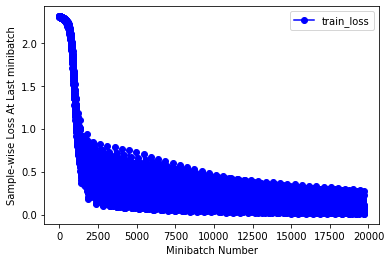

Epoch 43 :
Train accuracy: 97.770004 %
Train loss: 0.000617
Test accuracy: 96.909996 %
Test loss: 0.000771
Test accuracy adversarial: 16.010000 %
Test loss adversarial: 0.030307
Elapsed time for epoch: 2.0107405185699463 s
ETA of completion: 1.2399566531181336 minutes



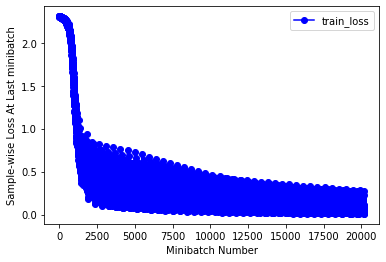

Epoch 44 :
Train accuracy: 97.828331 %
Train loss: 0.000600
Test accuracy: 96.959999 %
Test loss: 0.000759
Test accuracy adversarial: 15.730000 %
Test loss adversarial: 0.030766
Elapsed time for epoch: 2.0371384620666504 s
ETA of completion: 1.2222830772399902 minutes



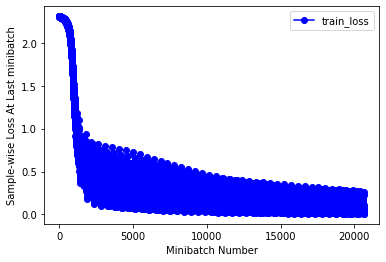

Epoch 45 :
Train accuracy: 97.900002 %
Train loss: 0.000582
Test accuracy: 96.979996 %
Test loss: 0.000748
Test accuracy adversarial: 15.559999 %
Test loss adversarial: 0.031226
Elapsed time for epoch: 2.1406989097595215 s
ETA of completion: 1.2487410306930542 minutes



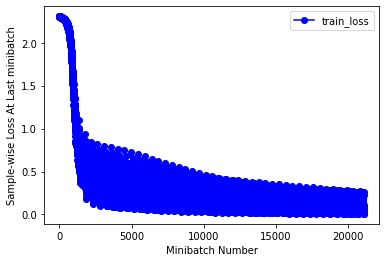

Epoch 46 :
Train accuracy: 97.961670 %
Train loss: 0.000566
Test accuracy: 97.070000 %
Test loss: 0.000738
Test accuracy adversarial: 15.339999 %
Test loss adversarial: 0.031675
Elapsed time for epoch: 2.048609495162964 s
ETA of completion: 1.1608787139256795 minutes



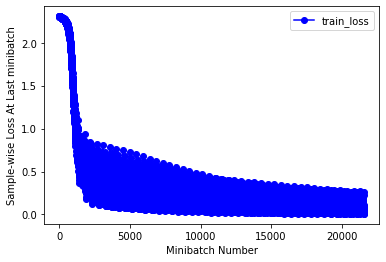

Epoch 47 :
Train accuracy: 98.025002 %
Train loss: 0.000549
Test accuracy: 97.110001 %
Test loss: 0.000728
Test accuracy adversarial: 15.009999 %
Test loss adversarial: 0.032135
Elapsed time for epoch: 2.0078916549682617 s
ETA of completion: 1.104340410232544 minutes



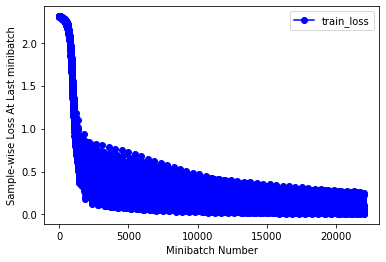

Epoch 48 :
Train accuracy: 98.081665 %
Train loss: 0.000534
Test accuracy: 97.189995 %
Test loss: 0.000719
Test accuracy adversarial: 14.679999 %
Test loss adversarial: 0.032620
Elapsed time for epoch: 1.9846084117889404 s
ETA of completion: 1.0584578196207681 minutes



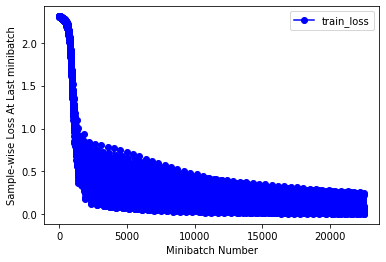

Epoch 49 :
Train accuracy: 98.133331 %
Train loss: 0.000519
Test accuracy: 97.209999 %
Test loss: 0.000710
Test accuracy adversarial: 14.440000 %
Test loss adversarial: 0.033097
Elapsed time for epoch: 1.95078444480896 s
ETA of completion: 1.0079052964846293 minutes



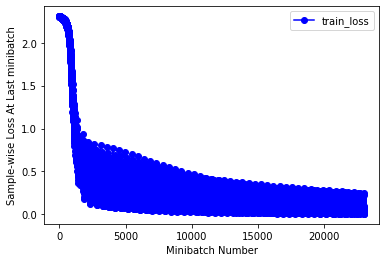

Epoch 50 :
Train accuracy: 98.213333 %
Train loss: 0.000504
Test accuracy: 97.299995 %
Test loss: 0.000702
Test accuracy adversarial: 14.099999 %
Test loss adversarial: 0.033562
Elapsed time for epoch: 2.0040853023529053 s
ETA of completion: 1.0020426511764526 minutes



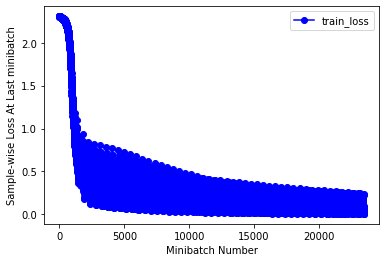

Epoch 51 :
Train accuracy: 98.256668 %
Train loss: 0.000490
Test accuracy: 97.299995 %
Test loss: 0.000694
Test accuracy adversarial: 13.889999 %
Test loss adversarial: 0.034043
Elapsed time for epoch: 1.9532299041748047 s
ETA of completion: 0.9440611203511556 minutes



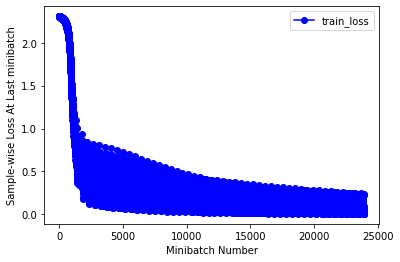

Epoch 52 :
Train accuracy: 98.320000 %
Train loss: 0.000476
Test accuracy: 97.329994 %
Test loss: 0.000686
Test accuracy adversarial: 13.660000 %
Test loss adversarial: 0.034510
Elapsed time for epoch: 1.9569721221923828 s
ETA of completion: 0.913253657023112 minutes



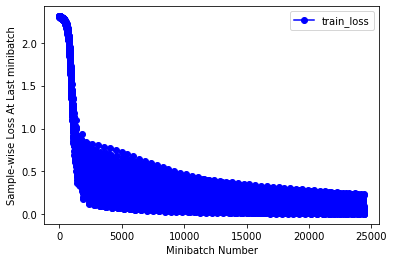

Epoch 53 :
Train accuracy: 98.364998 %
Train loss: 0.000463
Test accuracy: 97.360001 %
Test loss: 0.000679
Test accuracy adversarial: 13.549999 %
Test loss adversarial: 0.034995
Elapsed time for epoch: 1.9609403610229492 s
ETA of completion: 0.8824231624603271 minutes



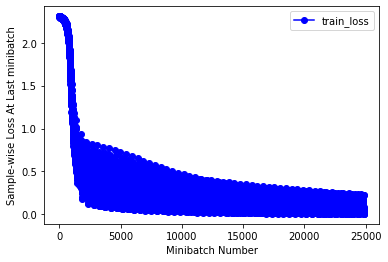

Epoch 54 :
Train accuracy: 98.403336 %
Train loss: 0.000450
Test accuracy: 97.379997 %
Test loss: 0.000672
Test accuracy adversarial: 13.389999 %
Test loss adversarial: 0.035486
Elapsed time for epoch: 1.9296972751617432 s
ETA of completion: 0.8362021525700887 minutes



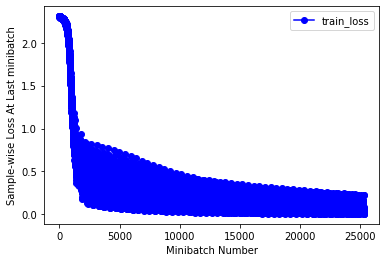

Epoch 55 :
Train accuracy: 98.450005 %
Train loss: 0.000438
Test accuracy: 97.389999 %
Test loss: 0.000666
Test accuracy adversarial: 13.160000 %
Test loss adversarial: 0.035967
Elapsed time for epoch: 1.9721167087554932 s
ETA of completion: 0.8217152953147888 minutes



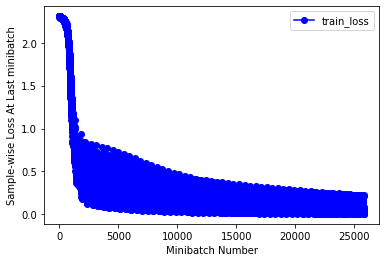

Epoch 56 :
Train accuracy: 98.508331 %
Train loss: 0.000425
Test accuracy: 97.439995 %
Test loss: 0.000659
Test accuracy adversarial: 12.910000 %
Test loss adversarial: 0.036454
Elapsed time for epoch: 1.961637020111084 s
ETA of completion: 0.7846548080444335 minutes



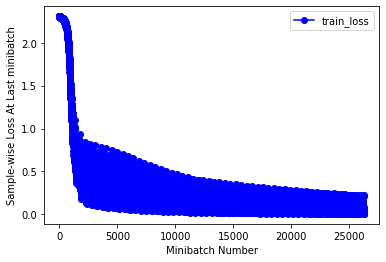

Epoch 57 :
Train accuracy: 98.546669 %
Train loss: 0.000414
Test accuracy: 97.419998 %
Test loss: 0.000654
Test accuracy adversarial: 12.740000 %
Test loss adversarial: 0.036958
Elapsed time for epoch: 1.9584925174713135 s
ETA of completion: 0.7507554650306701 minutes



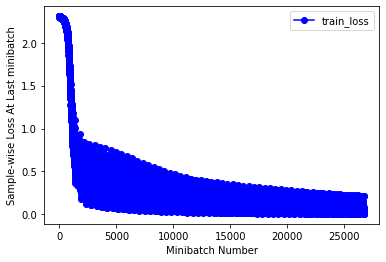

Epoch 58 :
Train accuracy: 98.605003 %
Train loss: 0.000402
Test accuracy: 97.439995 %
Test loss: 0.000648
Test accuracy adversarial: 12.370000 %
Test loss adversarial: 0.037469
Elapsed time for epoch: 1.972687005996704 s
ETA of completion: 0.7233185688654582 minutes



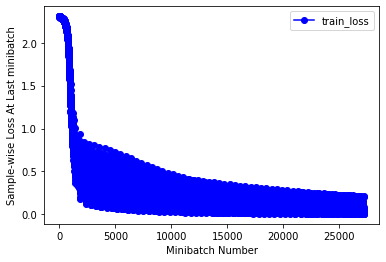

Epoch 59 :
Train accuracy: 98.650002 %
Train loss: 0.000391
Test accuracy: 97.430000 %
Test loss: 0.000643
Test accuracy adversarial: 12.170000 %
Test loss adversarial: 0.037978
Elapsed time for epoch: 2.088726282119751 s
ETA of completion: 0.7310541987419128 minutes



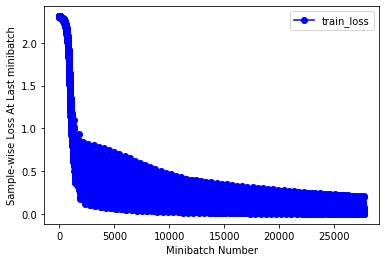

Epoch 60 :
Train accuracy: 98.691666 %
Train loss: 0.000381
Test accuracy: 97.430000 %
Test loss: 0.000638
Test accuracy adversarial: 11.980000 %
Test loss adversarial: 0.038453
Elapsed time for epoch: 1.9918437004089355 s
ETA of completion: 0.6639479001363119 minutes



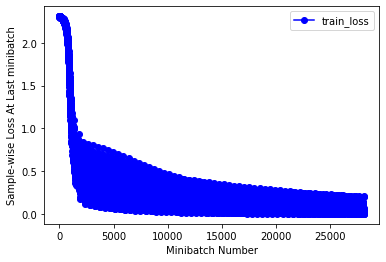

Epoch 61 :
Train accuracy: 98.748337 %
Train loss: 0.000370
Test accuracy: 97.459999 %
Test loss: 0.000633
Test accuracy adversarial: 11.799999 %
Test loss adversarial: 0.038969
Elapsed time for epoch: 1.9385075569152832 s
ETA of completion: 0.6138607263565063 minutes



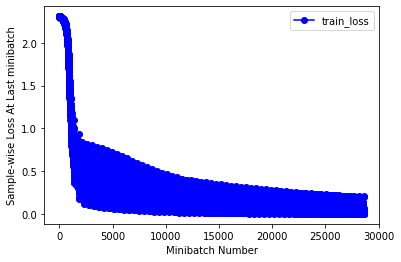

Epoch 62 :
Train accuracy: 98.790001 %
Train loss: 0.000360
Test accuracy: 97.470001 %
Test loss: 0.000629
Test accuracy adversarial: 11.660000 %
Test loss adversarial: 0.039463
Elapsed time for epoch: 1.9913337230682373 s
ETA of completion: 0.5974001169204712 minutes



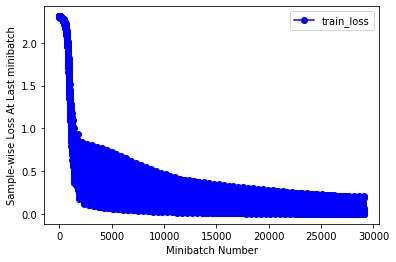

Epoch 63 :
Train accuracy: 98.836670 %
Train loss: 0.000350
Test accuracy: 97.519997 %
Test loss: 0.000624
Test accuracy adversarial: 11.370000 %
Test loss adversarial: 0.039971
Elapsed time for epoch: 1.936246395111084 s
ETA of completion: 0.5486031452814738 minutes



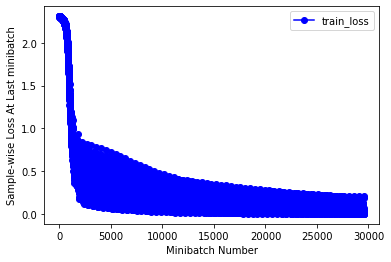

Epoch 64 :
Train accuracy: 98.873337 %
Train loss: 0.000341
Test accuracy: 97.549995 %
Test loss: 0.000620
Test accuracy adversarial: 11.090000 %
Test loss adversarial: 0.040486
Elapsed time for epoch: 1.966160535812378 s
ETA of completion: 0.5243094762166342 minutes



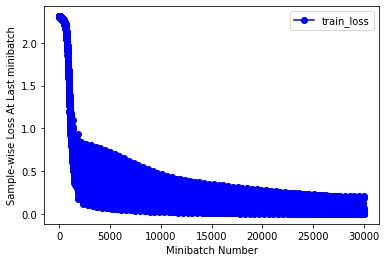

Epoch 65 :
Train accuracy: 98.908333 %
Train loss: 0.000332
Test accuracy: 97.589996 %
Test loss: 0.000616
Test accuracy adversarial: 10.969999 %
Test loss adversarial: 0.040992
Elapsed time for epoch: 1.9467694759368896 s
ETA of completion: 0.4866923689842224 minutes



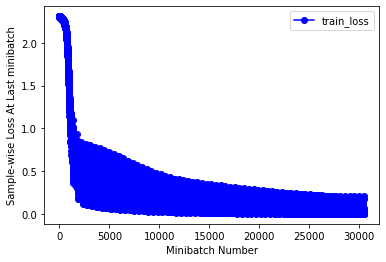

Epoch 66 :
Train accuracy: 98.928337 %
Train loss: 0.000323
Test accuracy: 97.599998 %
Test loss: 0.000613
Test accuracy adversarial: 10.759999 %
Test loss adversarial: 0.041507
Elapsed time for epoch: 1.9452805519104004 s
ETA of completion: 0.4538987954457601 minutes



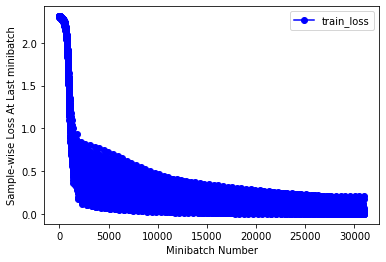

Epoch 67 :
Train accuracy: 98.971664 %
Train loss: 0.000314
Test accuracy: 97.610001 %
Test loss: 0.000609
Test accuracy adversarial: 10.650000 %
Test loss adversarial: 0.042041
Elapsed time for epoch: 1.9526634216308594 s
ETA of completion: 0.4230770746866862 minutes



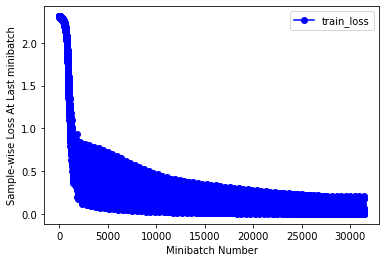

Epoch 68 :
Train accuracy: 99.008331 %
Train loss: 0.000305
Test accuracy: 97.649994 %
Test loss: 0.000605
Test accuracy adversarial: 10.550000 %
Test loss adversarial: 0.042537
Elapsed time for epoch: 1.94187593460083 s
ETA of completion: 0.38837518692016604 minutes



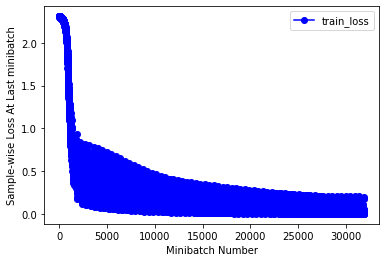

Epoch 69 :
Train accuracy: 99.048332 %
Train loss: 0.000297
Test accuracy: 97.669998 %
Test loss: 0.000602
Test accuracy adversarial: 10.280000 %
Test loss adversarial: 0.043076
Elapsed time for epoch: 1.9865365028381348 s
ETA of completion: 0.36419835885365803 minutes



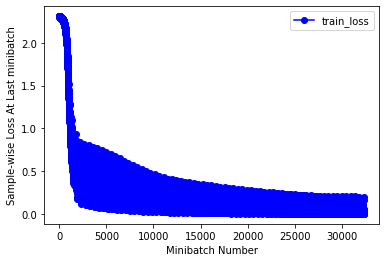

Epoch 70 :
Train accuracy: 99.078331 %
Train loss: 0.000289
Test accuracy: 97.680000 %
Test loss: 0.000598
Test accuracy adversarial: 10.120000 %
Test loss adversarial: 0.043586
Elapsed time for epoch: 1.9819996356964111 s
ETA of completion: 0.33033327261606854 minutes



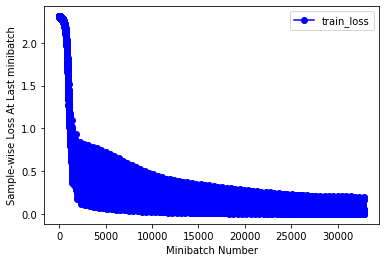

Epoch 71 :
Train accuracy: 99.111671 %
Train loss: 0.000281
Test accuracy: 97.669998 %
Test loss: 0.000596
Test accuracy adversarial: 9.910000 %
Test loss adversarial: 0.044131
Elapsed time for epoch: 1.9409115314483643 s
ETA of completion: 0.2911367297172546 minutes



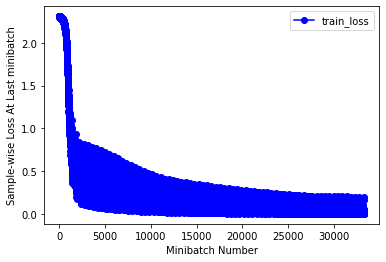

Epoch 72 :
Train accuracy: 99.145004 %
Train loss: 0.000273
Test accuracy: 97.659996 %
Test loss: 0.000593
Test accuracy adversarial: 9.820000 %
Test loss adversarial: 0.044647
Elapsed time for epoch: 2.020855188369751 s
ETA of completion: 0.2694473584493001 minutes



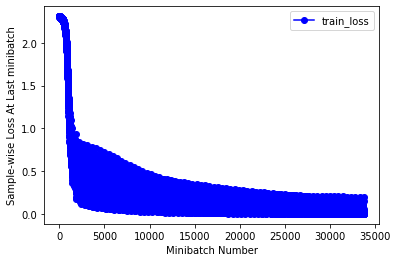

Epoch 73 :
Train accuracy: 99.175003 %
Train loss: 0.000266
Test accuracy: 97.659996 %
Test loss: 0.000591
Test accuracy adversarial: 9.639999 %
Test loss adversarial: 0.045192
Elapsed time for epoch: 1.9497590065002441 s
ETA of completion: 0.22747188409169514 minutes



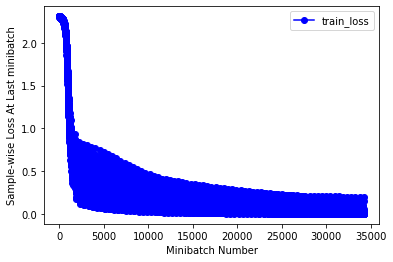

Epoch 74 :
Train accuracy: 99.209999 %
Train loss: 0.000259
Test accuracy: 97.680000 %
Test loss: 0.000589
Test accuracy adversarial: 9.620000 %
Test loss adversarial: 0.045735
Elapsed time for epoch: 1.949225902557373 s
ETA of completion: 0.1949225902557373 minutes



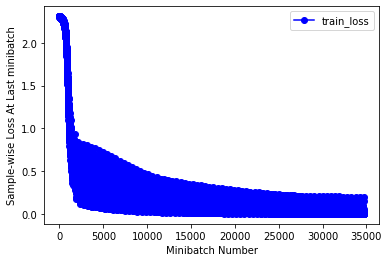

Epoch 75 :
Train accuracy: 99.238335 %
Train loss: 0.000252
Test accuracy: 97.669998 %
Test loss: 0.000586
Test accuracy adversarial: 9.520000 %
Test loss adversarial: 0.046268
Elapsed time for epoch: 1.9387128353118896 s
ETA of completion: 0.16155940294265747 minutes



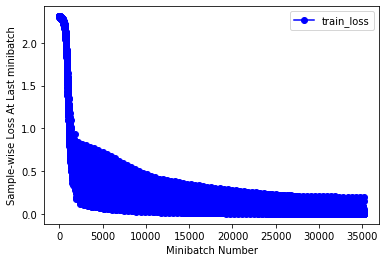

Epoch 76 :
Train accuracy: 99.271667 %
Train loss: 0.000245
Test accuracy: 97.689995 %
Test loss: 0.000584
Test accuracy adversarial: 9.410000 %
Test loss adversarial: 0.046804
Elapsed time for epoch: 1.9848823547363281 s
ETA of completion: 0.13232549031575522 minutes



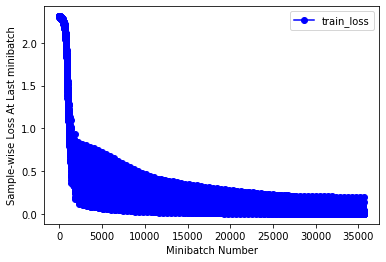

Epoch 77 :
Train accuracy: 99.298332 %
Train loss: 0.000239
Test accuracy: 97.709999 %
Test loss: 0.000582
Test accuracy adversarial: 9.219999 %
Test loss adversarial: 0.047352
Elapsed time for epoch: 1.964585542678833 s
ETA of completion: 0.09822927713394165 minutes



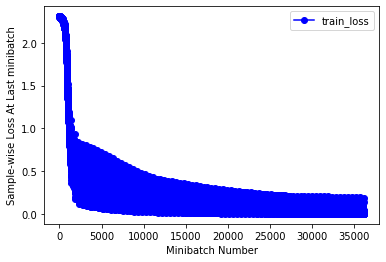

Epoch 78 :
Train accuracy: 99.320000 %
Train loss: 0.000232
Test accuracy: 97.709999 %
Test loss: 0.000580
Test accuracy adversarial: 9.240000 %
Test loss adversarial: 0.047890
Elapsed time for epoch: 1.9723656177520752 s
ETA of completion: 0.06574552059173584 minutes



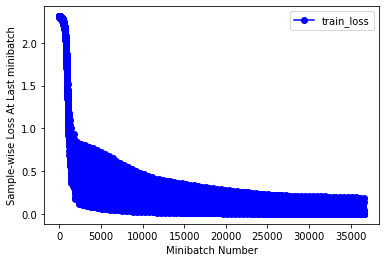

Epoch 79 :
Train accuracy: 99.343338 %
Train loss: 0.000226
Test accuracy: 97.720001 %
Test loss: 0.000578
Test accuracy adversarial: 9.139999 %
Test loss adversarial: 0.048439
Elapsed time for epoch: 1.9521548748016357 s
ETA of completion: 0.03253591458002726 minutes



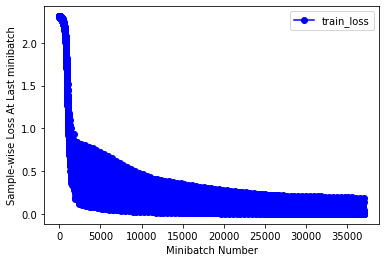

Epoch 80 :
Train accuracy: 99.368332 %
Train loss: 0.000220
Test accuracy: 97.699997 %
Test loss: 0.000577
Test accuracy adversarial: 9.099999 %
Test loss adversarial: 0.048961
Elapsed time for epoch: 1.94309663772583 s
ETA of completion: 0.0 minutes



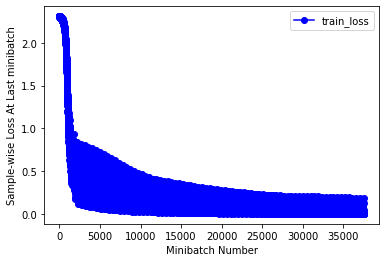

In [19]:
#number of epochs to train for:
epochs = 80

#define batch train loss recording array for later visualization/plotting:
loss_batch_store = []

print("Starting Training")
#training loop:
for epoch in range(epochs):
    time1 = time.time() #timekeeping

    for i, (x,y) in enumerate(train_loader):

        if gpu_boole:
          x = x.cuda()
          y = y.cuda()

        x = x.view(x.shape[0],-1)

        #loss calculation and gradient update:

        if i > 0 or epoch > 0:
            optimizer.zero_grad()
        outputs = net.forward(x)
        loss = loss_metric(outputs,y)
        loss.backward()

        if i > 0 or epoch > 0:
            loss_batch_store.append(loss.cpu().data.numpy().item())

        ##perform update:
        optimizer.step()

    print("Epoch",epoch+1,':')
    train_perc, train_loss = train_eval()
    test_perc, test_loss = test_eval()
    test_eval_adv()

    time2 = time.time() #timekeeping
    print('Elapsed time for epoch:',time2 - time1,'s')
    print('ETA of completion:',(time2 - time1)*(epochs - epoch - 1)/60,'minutes')
    print()

    ## Plot batch-wise train loss curve:
    plt.plot(loss_batch_store, '-o', label = 'train_loss', color = 'blue')
    plt.xlabel('Minibatch Number')
    plt.ylabel('Sample-wise Loss At Last minibatch')
    plt.legend()
    plt.show()

Visualize Some Examples

Visualize a original Image and its corresponding adversarial example.

Print the prediction of the model for both of the images.

The adversarial sample should look similar to the original image and be easily and correctly classified by a human.

tensor([3], device='cuda:0')


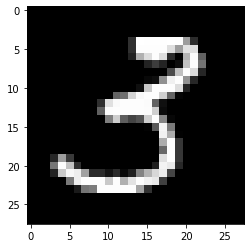

In [ ]:
plt.imshow(x[0].cpu().reshape(28,28),cmap='gray')
print(net(x[0].view(-1,784)).argmax(dim=1))

tensor(5, device='cuda:0')


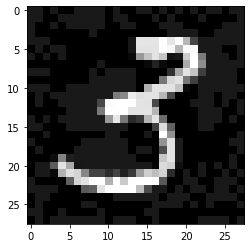

In [ ]:
labels = net(x[0].view(-1,784)).argmax(dim=1)
in_x = Variable(x[[0]], requires_grad=True)
adv_x = adv_attack.forward(in_x, labels, net)
plt.imshow(adv_x[0].detach().cpu().reshape(28,28),cmap='gray')
print(net(adv_x[0].view(-1,784)).argmax(dim=1)[0])

### Part 2: CIFAR Attack

Now, you will attempt to use the same type of adversarial attack against a CIFAR classifier. You should use code structured similarly to that from above. We provide some struture below to get you started. We recommend trying the resnet50 model to begin, but feel free to experiment with model architectures and hyperparameters.

In [ ]:
import torch
import torchvision
from torchvision.models import vgg16, resnet50
import torchvision.transforms as transforms

In [ ]:
## Transformations
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.Resize(64)])

## Batch Size
batch_size = 128

## Dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
## Helper
def initialize_model(use_resnet=True, pretrained=False, nclasses=10):
    """
    
    """
    ## Initialize Model
    if use_resnet:
        model = resnet50(pretrained=pretrained)
    else:
        model = vgg16(pretrained=True)
    ## Freeze Early Layers if Pretrained
    if pretrained:
        for parameter in model.parameters():
            parameter.requires_grad = False
    ## Update Output Layer
    if use_resnet:
        model.fc = nn.Linear(2048, nclasses)
    else:
        model.classifier._modules['6'] = nn.Linear(4096, nclasses)
    return model

## Get Model
net = initialize_model(True, False, 10)

### TODO: Train the model using the same structure as before

In [ ]:
if gpu_boole:
    net = net.cuda()

optimizer = torch.optim.SGD(net.parameters(), lr = 0.01)
loss_metric = nn.CrossEntropyLoss()
#use adversarial attack
adv_attack = GradientAttack(loss_metric, 0.1)

In [ ]:
## Evaluation Functions (E.g Loss, Accuracy)
def train_eval(verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    for images, labels in trainloader:
        if gpu_boole:
            images, labels = images.cuda(), labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.float() == labels.float()).sum()

        loss_sum += loss_metric(outputs,labels).item()
        
    if verbose:
        print('Train accuracy: %f %%' % (100.0 * correct / total))
        print('Train loss: %f' % (loss_sum / total))

    return 100.0 * correct / total, loss_sum / total
    
def test_eval(verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    for images, labels in testloader:
        if gpu_boole:
            images, labels = images.cuda(), labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.float() == labels.float()).sum()

        loss_sum += loss_metric(outputs,labels).item()

    if verbose:
        print('Test accuracy: %f %%' % (100.0 * correct / total))
        print('Test loss: %f' % (loss_sum / total))

    return 100.0 * correct / total, loss_sum / total

def test_eval_adv(verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    for images, labels in testloader:
        if gpu_boole:
            images, labels = images.cuda(), labels.cuda()
        images = Variable(images, requires_grad=True)
        images = adv_attack.forward(images, Variable(labels), net)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.float() == labels.float()).sum()

        loss_sum += loss_metric(outputs,labels).item()

    if verbose:
        print('Test accuracy adversarial: %f %%' % (100.0 * correct / total))
        print('Test loss adversarial: %f' % (loss_sum / total))

    return 100.0 * correct / total, loss_sum / total

Starting Training
Epoch 1 :
Train accuracy: 26.171999 %
Train loss: 0.015761
Test accuracy: 26.160000 %
Test loss: 0.015976
Test accuracy adversarial: 21.309999 %
Test loss adversarial: 0.017942
Elapsed time for epoch: 91.81090378761292 s
ETA of completion: 36.72436151504517 minutes



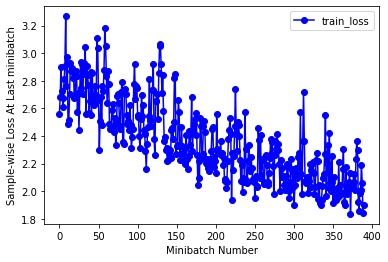

Epoch 2 :
Train accuracy: 36.422001 %
Train loss: 0.013652
Test accuracy: 36.250000 %
Test loss: 0.013984
Test accuracy adversarial: 27.099998 %
Test loss adversarial: 0.016784
Elapsed time for epoch: 91.86406779289246 s
ETA of completion: 35.21455932060878 minutes



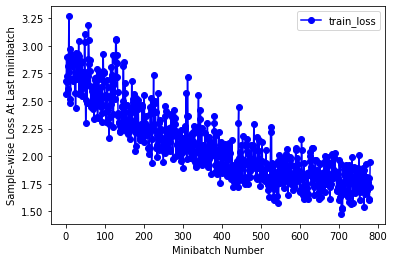

Epoch 3 :
Test accuracy: 40.169998 %
Test loss: 0.013347
Test accuracy adversarial: 28.260000 %
Test loss adversarial: 0.016725
Elapsed time for epoch: 91.97824430465698 s
ETA of completion: 33.72535624504089 minutes



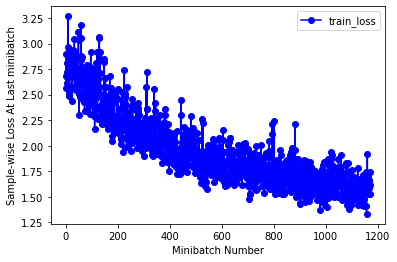

Epoch 4 :
Train accuracy: 49.023998 %
Train loss: 0.011005
Test accuracy: 46.189999 %
Test loss: 0.011830
Test accuracy adversarial: 28.170000 %
Test loss adversarial: 0.016591
Elapsed time for epoch: 92.59185671806335 s
ETA of completion: 32.407149851322174 minutes



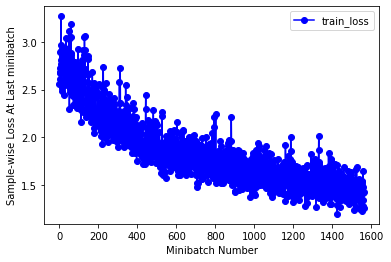

Epoch 5 :
Train accuracy: 53.445999 %
Train loss: 0.010067
Test accuracy: 48.480000 %
Test loss: 0.011217
Test accuracy adversarial: 28.869999 %
Test loss adversarial: 0.016552
Elapsed time for epoch: 92.21169972419739 s
ETA of completion: 30.737233241399128 minutes



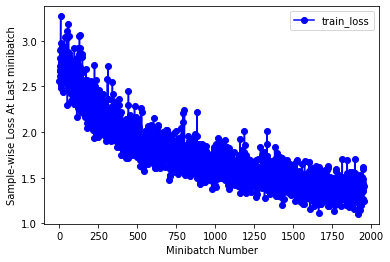

Epoch 6 :
Train accuracy: 55.299999 %
Train loss: 0.009643
Test accuracy: 49.599998 %
Test loss: 0.011239
Test accuracy adversarial: 28.660000 %
Test loss adversarial: 0.017168
Elapsed time for epoch: 92.65637063980103 s
ETA of completion: 29.34118403593699 minutes



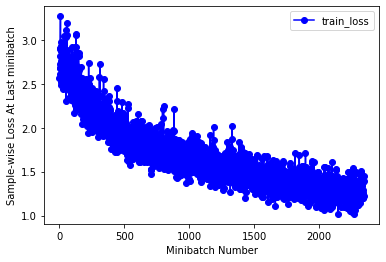

Epoch 7 :
Train accuracy: 56.514000 %
Train loss: 0.009258
Test accuracy: 49.789997 %
Test loss: 0.011337
Test accuracy adversarial: 27.349998 %
Test loss adversarial: 0.018560
Elapsed time for epoch: 92.72556495666504 s
ETA of completion: 27.817669486999513 minutes



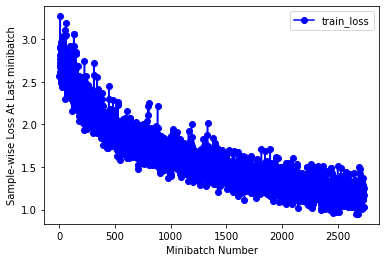

Epoch 8 :
Train accuracy: 64.223999 %
Train loss: 0.007873
Test accuracy: 53.469997 %
Test loss: 0.010495
Test accuracy adversarial: 27.129999 %
Test loss adversarial: 0.018507
Elapsed time for epoch: 92.99067997932434 s
ETA of completion: 26.34735932747523 minutes



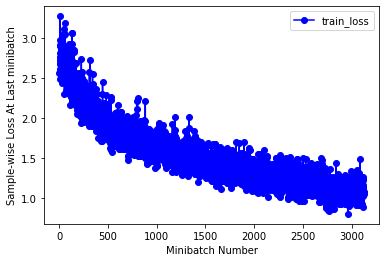

Epoch 9 :
Train accuracy: 69.323997 %
Train loss: 0.006781
Test accuracy: 55.829998 %
Test loss: 0.010094
Test accuracy adversarial: 28.900000 %
Test loss adversarial: 0.018900
Elapsed time for epoch: 93.01370000839233 s
ETA of completion: 24.80365333557129 minutes



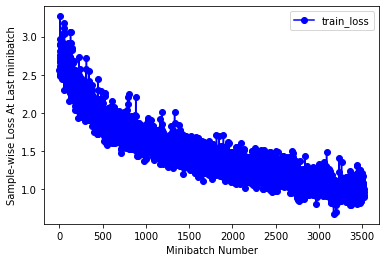

Epoch 10 :
Train accuracy: 73.580002 %
Train loss: 0.005938
Test accuracy: 56.930000 %
Test loss: 0.010121
Test accuracy adversarial: 29.619999 %
Test loss adversarial: 0.019491
Elapsed time for epoch: 93.08019042015076 s
ETA of completion: 23.27004760503769 minutes



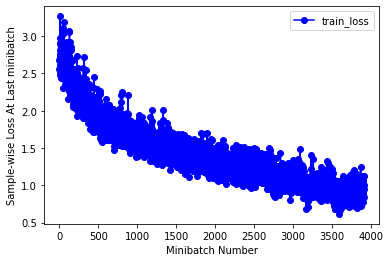

Epoch 11 :
Train accuracy: 76.755997 %
Train loss: 0.005304
Test accuracy: 56.660000 %
Test loss: 0.010382
Test accuracy adversarial: 28.410000 %
Test loss adversarial: 0.020274
Elapsed time for epoch: 93.13074541091919 s
ETA of completion: 21.73050726254781 minutes



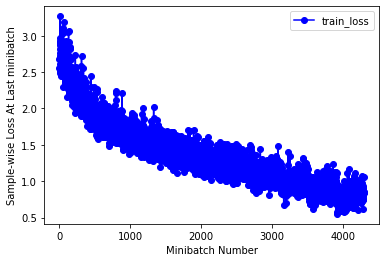

Epoch 12 :
Train accuracy: 80.559998 %
Train loss: 0.004451
Test accuracy: 56.969997 %
Test loss: 0.010660
Test accuracy adversarial: 28.910000 %
Test loss adversarial: 0.021157
Elapsed time for epoch: 93.0923821926117 s
ETA of completion: 20.170016141732535 minutes



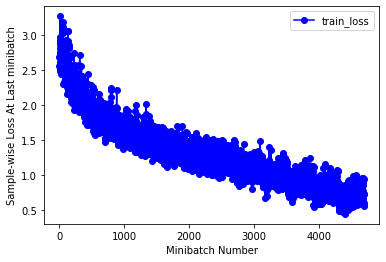

Epoch 13 :
Train accuracy: 81.241997 %
Train loss: 0.004164
Test accuracy: 55.399998 %
Test loss: 0.011492
Test accuracy adversarial: 29.529999 %
Test loss adversarial: 0.023565
Elapsed time for epoch: 92.59361290931702 s
ETA of completion: 18.518722581863404 minutes



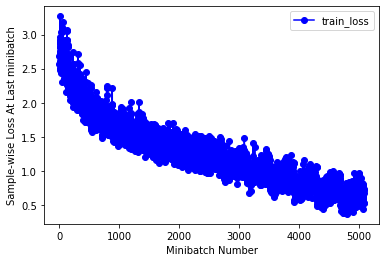

Epoch 14 :
Train accuracy: 85.888000 %
Train loss: 0.003206
Test accuracy: 56.590000 %
Test loss: 0.011758
Test accuracy adversarial: 29.139999 %
Test loss adversarial: 0.024230
Elapsed time for epoch: 92.56999945640564 s
ETA of completion: 16.9711665670077 minutes



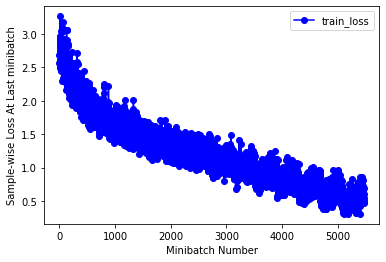

Epoch 15 :
Train accuracy: 87.369995 %
Train loss: 0.002842
Test accuracy: 57.509998 %
Test loss: 0.012499
Test accuracy adversarial: 30.039999 %
Test loss adversarial: 0.026212
Elapsed time for epoch: 91.55082821846008 s
ETA of completion: 15.258471369743347 minutes



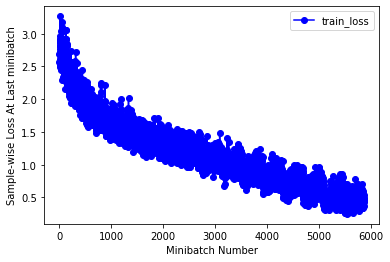

Epoch 16 :
Train accuracy: 89.500000 %
Train loss: 0.002354
Test accuracy: 57.859997 %
Test loss: 0.013103
Test accuracy adversarial: 29.990000 %
Test loss adversarial: 0.027290
Elapsed time for epoch: 92.14917635917664 s
ETA of completion: 13.822376453876496 minutes



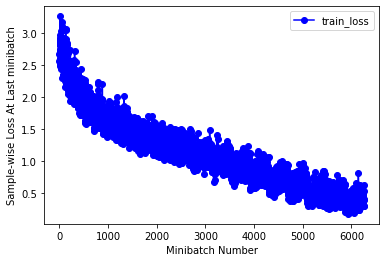

Epoch 17 :
Train accuracy: 90.526001 %
Train loss: 0.002116
Test accuracy: 56.989998 %
Test loss: 0.013632
Test accuracy adversarial: 30.699999 %
Test loss adversarial: 0.029054
Elapsed time for epoch: 91.8663055896759 s
ETA of completion: 12.24884074529012 minutes



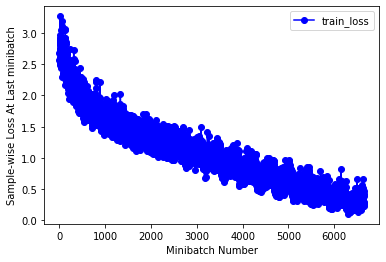

Epoch 18 :
Train accuracy: 91.570000 %
Train loss: 0.001927
Test accuracy: 56.609997 %
Test loss: 0.014705
Test accuracy adversarial: 30.259998 %
Test loss adversarial: 0.031402
Elapsed time for epoch: 91.31646227836609 s
ETA of completion: 10.653587265809376 minutes



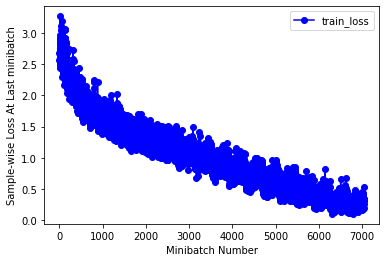

Epoch 19 :
Train accuracy: 93.329994 %
Train loss: 0.001505
Test accuracy: 56.930000 %
Test loss: 0.015054
Test accuracy adversarial: 29.830000 %
Test loss adversarial: 0.032309
Elapsed time for epoch: 91.84272289276123 s
ETA of completion: 9.184272289276123 minutes



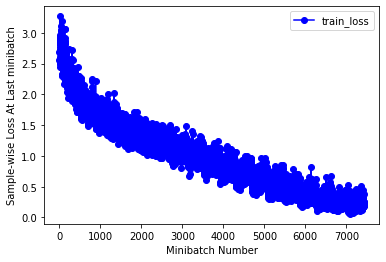

Epoch 20 :
Train accuracy: 94.785995 %
Train loss: 0.001180
Test accuracy: 57.949997 %
Test loss: 0.015290
Test accuracy adversarial: 30.000000 %
Test loss adversarial: 0.032656
Elapsed time for epoch: 92.65404391288757 s
ETA of completion: 7.721170326073964 minutes



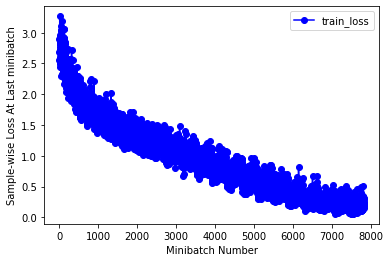

Epoch 21 :
Train accuracy: 93.944000 %
Train loss: 0.001399
Test accuracy: 57.270000 %
Test loss: 0.015716
Test accuracy adversarial: 29.150000 %
Test loss adversarial: 0.035954
Elapsed time for epoch: 91.32745885848999 s
ETA of completion: 6.088497257232666 minutes



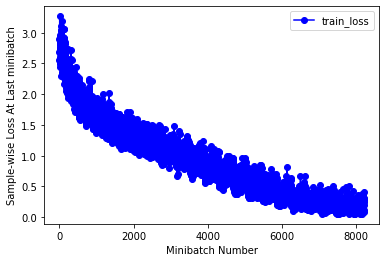

Epoch 22 :
Train accuracy: 95.477997 %
Train loss: 0.001043
Test accuracy: 57.369999 %
Test loss: 0.016508
Test accuracy adversarial: 29.449999 %
Test loss adversarial: 0.035719
Elapsed time for epoch: 92.95984649658203 s
ETA of completion: 4.647992324829102 minutes



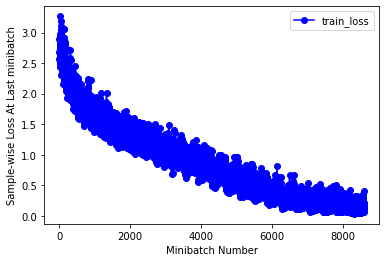

Epoch 23 :
Train accuracy: 93.958000 %
Train loss: 0.001403
Test accuracy: 56.239998 %
Test loss: 0.017880
Test accuracy adversarial: 28.629999 %
Test loss adversarial: 0.039539
Elapsed time for epoch: 92.54137468338013 s
ETA of completion: 3.0847124894460043 minutes



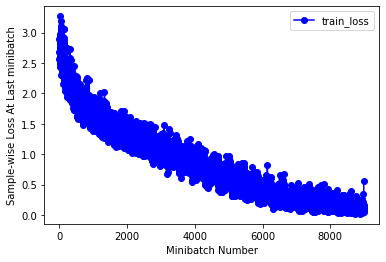

Epoch 24 :
Train accuracy: 96.951996 %
Train loss: 0.000694
Test accuracy: 58.949997 %
Test loss: 0.016759
Test accuracy adversarial: 30.660000 %
Test loss adversarial: 0.037907
Elapsed time for epoch: 91.14007139205933 s
ETA of completion: 1.5190011898676554 minutes



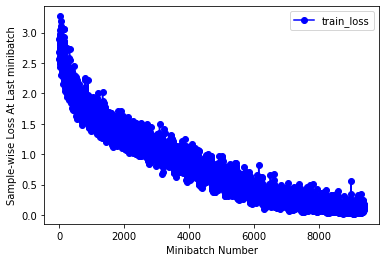

Epoch 25 :
Train accuracy: 96.615997 %
Train loss: 0.000780
Test accuracy: 59.099998 %
Test loss: 0.017525
Test accuracy adversarial: 30.559999 %
Test loss adversarial: 0.039053
Elapsed time for epoch: 91.23587918281555 s
ETA of completion: 0.0 minutes



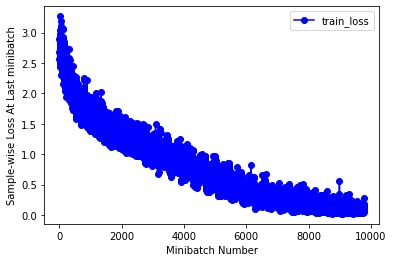

In [ ]:
#number of epochs to train for:
epochs = 25

#define batch train loss recording array for later visualization/plotting:
loss_batch_store = []

print("Starting Training")
#training loop:
for epoch in range(epochs):
    time1 = time.time() #timekeeping

    for i, (x,y) in enumerate(trainloader):

        if gpu_boole:
          x = x.cuda()
          y = y.cuda()

        #x = x.view(x.shape[0],-1)

        #loss calculation and gradient update:

        if i > 0 or epoch > 0:
            optimizer.zero_grad()
        outputs = net.forward(x)
        loss = loss_metric(outputs,y)
        loss.backward()

        if i > 0 or epoch > 0:
            loss_batch_store.append(loss.cpu().data.numpy().item())

        ##perform update:
        optimizer.step()

    print("Epoch",epoch+1,':')
    train_perc, train_loss = train_eval()
    test_perc, test_loss = test_eval()
    test_eval_adv()

    time2 = time.time() #timekeeping
    print('Elapsed time for epoch:',time2 - time1,'s')
    print('ETA of completion:',(time2 - time1)*(epochs - epoch - 1)/60,'minutes')
    print()

    ## Plot batch-wise train loss curve:
    plt.plot(loss_batch_store, '-o', label = 'train_loss', color = 'blue')
    plt.xlabel('Minibatch Number')
    plt.ylabel('Sample-wise Loss At Last minibatch')
    plt.legend()
    plt.show()
#save model
PATH = "gdrive/MyDrive/'real_world.pt'"
torch.save(net, PATH)
#load
#the_model = torch.load(PATH)

### Part 3: Real World Example

Use your phone or other camera device to take a picture of an item you would find in CIFAR-10. Upload the photo to this notebook and format it so that it can be analyzed by your image classifier and the adversarial example generator.

In [ ]:
!unzip 'gdrive/MyDrive/real_world.zip'

Archive:  gdrive/MyDrive/real_world.zip
   creating: real_world/
   creating: real_world/0/
  inflating: real_world/0/cat.0.jpg  
  inflating: real_world/0/cat.1.jpg  
   creating: real_world/1/
  inflating: real_world/1/dog.0.jpg  
  inflating: real_world/1/dog.1.jpg  


In [ ]:
## Complete your work below
import torch.utils.data as data


#transformation
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.Resize(64)])

#read my own dataset
class MyDataset(data.Dataset):
    def __init__(self, root, transform):
        import os
        self.train_class = os.listdir(root)                                             
        self.class_list = [os.path.join(root, k) for k in self.train_class]              
        self.imgs = []                                                                       
        for i, j in enumerate(self.class_list):
            imgs = os.listdir(j)                                                              
            self.temp = [(os.path.join(j, k), int(self.train_class[i])) for k in imgs]        
            self.imgs += self.temp                                                            
        self.transforms = transform

    def __getitem__(self, index):
        from PIL import Image
        img_path, label = self.imgs[index]                                                   
        pil_img = Image.open(img_path).convert('RGB')                                         
        if self.transforms:                                                                  
            img = self.transforms(pil_img)
        else:
            pil_img = np.asarray(pil_img)
            img = torch.from_numpy(pil_img)
        return img, label

    def __len__(self):
        return len(self.imgs)

root = 'gdrive/MyDrive/real_world' 
real_world_data = MyDataset(root, transform)
real_world_loader = torch.utils.data.DataLoader(real_world_data, batch_size=1, shuffle=False)

###one example of my photos

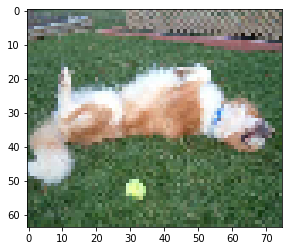

In [ ]:
from pylab import *
def imshow(img):
    img = img / 2 + 0.5   
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(real_world_loader)
images, labels = dataiter.next()

# show one of the photos from of my real_world example
imshow(torchvision.utils.make_grid(images))

In [ ]:
#load model
PATH = "gdrive/MyDrive/'real_world.pt'"
net = torch.load(PATH)
#evaluate model without adversarial
for images, labels in real_world_loader:
        if gpu_boole:
            images, labels = images.cuda(), labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        print("The prediction label is:",predicted.data)

The prediction label is: tensor([0], device='cuda:0')
The prediction label is: tensor([2], device='cuda:0')
The prediction label is: tensor([2], device='cuda:0')
The prediction label is: tensor([0], device='cuda:0')


In [ ]:
#evaluate model with adversarial
for images, labels in real_world_loader:
        if gpu_boole:
            images, labels = images.cuda(), labels.cuda()
        images = Variable(images, requires_grad=True)
        images = adv_attack.forward(images, Variable(labels), net)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        print("The prediction label is:",predicted.data)

The prediction label is: tensor([0], device='cuda:0')
The prediction label is: tensor([2], device='cuda:0')
The prediction label is: tensor([0], device='cuda:0')
The prediction label is: tensor([0], device='cuda:0')


According to these results, I find that the cats and dogs in my real world images are misclassified as airplanes and birds in CIFAR10 dataset. And the classifier is more likely to predict my images as airplane when I introduce attacks on the dataset.